<a href="https://colab.research.google.com/github/Lord-Kanzler/DS-Unit-2-Linear-Models/blob/master/module3-ridge-regression/LS_DS_213_assignment_ALEX_KAISER.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 1, Module 3*

---

# Ridge Regression

## Assignment

We're going back to our other **New York City** real estate dataset. Instead of predicting apartment rents, you'll predict property sales prices.

But not just for condos in Tribeca...

- [ ] Use a subset of the data where `BUILDING_CLASS_CATEGORY` == `'01 ONE FAMILY DWELLINGS'` and the sale price was more than 100 thousand and less than 2 million.
- [ ] Do train/test split. Use data from January — March 2019 to train. Use data from April 2019 to test.
- [ ] Do one-hot encoding of categorical features.
- [ ] Do feature selection with `SelectKBest`.
- [ ] Fit a ridge regression model with multiple features. Use the `normalize=True` parameter (or do [feature scaling](https://scikit-learn.org/stable/modules/preprocessing.html) beforehand — use the scaler's `fit_transform` method with the train set, and the scaler's `transform` method with the test set)
- [ ] Get mean absolute error for the test set.
- [ ] As always, commit your notebook to your fork of the GitHub repo.

The [NYC Department of Finance](https://www1.nyc.gov/site/finance/taxes/property-rolling-sales-data.page) has a glossary of property sales terms and NYC Building Class Code Descriptions. The data comes from the [NYC OpenData](https://data.cityofnewyork.us/browse?q=NYC%20calendar%20sales) portal.


## Stretch Goals

Don't worry, you aren't expected to do all these stretch goals! These are just ideas to consider and choose from.

- [ ] Add your own stretch goal(s) !
- [ ] Instead of `Ridge`, try `LinearRegression`. Depending on how many features you select, your errors will probably blow up! 💥
- [ ] Instead of `Ridge`, try [`RidgeCV`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html).
- [ ] Learn more about feature selection:
    - ["Permutation importance"](https://www.kaggle.com/dansbecker/permutation-importance)
    - [scikit-learn's User Guide for Feature Selection](https://scikit-learn.org/stable/modules/feature_selection.html)
    - [mlxtend](http://rasbt.github.io/mlxtend/) library
    - scikit-learn-contrib libraries: [boruta_py](https://github.com/scikit-learn-contrib/boruta_py) & [stability-selection](https://github.com/scikit-learn-contrib/stability-selection)
    - [_Feature Engineering and Selection_](http://www.feat.engineering/) by Kuhn & Johnson.
- [ ] Try [statsmodels](https://www.statsmodels.org/stable/index.html) if you’re interested in more inferential statistical approach to linear regression and feature selection, looking at p values and 95% confidence intervals for the coefficients.
- [ ] Read [_An Introduction to Statistical Learning_](http://faculty.marshall.usc.edu/gareth-james/ISL/ISLR%20Seventh%20Printing.pdf), Chapters 1-3, for more math & theory, but in an accessible, readable way.
- [ ] Try [scikit-learn pipelines](https://scikit-learn.org/stable/modules/compose.html).

In [0]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'
    
# Ignore this Numpy warning when using Plotly Express:
# FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='numpy')

In [0]:
import pandas as pd
import pandas_profiling

# Read New York City property sales data
df = pd.read_csv(DATA_PATH+'condos/NYC_Citywide_Rolling_Calendar_Sales.csv')

# Change column names: replace spaces with underscores
df.columns = [col.replace(' ', '_') for col in df]

# SALE_PRICE was read as strings.
# Remove symbols, convert to integer
df['SALE_PRICE'] = (
    df['SALE_PRICE']
    .str.replace('$','')
    .str.replace('-','')
    .str.replace(',','')
    .astype(int)
)

In [0]:
# BOROUGH is a numeric column, but arguably should be a categorical feature,
# so convert it from a number to a string
df['BOROUGH'] = df['BOROUGH'].astype(str)

In [0]:
# Reduce cardinality for NEIGHBORHOOD feature

# Get a list of the top 10 neighborhoods
top10 = df['NEIGHBORHOOD'].value_counts()[:10].index

# At locations where the neighborhood is NOT in the top 10, 
# replace the neighborhood with 'OTHER'
df.loc[~df['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'

In [5]:
import numpy as np

print(df.shape)
df.head()

(23040, 21)


,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,EASE-MENT,BUILDING_CLASS_AT_PRESENT,ADDRESS,APARTMENT_NUMBER,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE
0,1,OTHER,13 CONDOS - ELEVATOR APARTMENTS,2,716,1246,NaN,R4,"447 WEST 18TH STREET, PH12A",PH12A,10011.0,1.0,0.0,1.0,"10,733",1979.0,2007.0,2,R4,0,01/01/2019
1,1,OTHER,21 OFFICE BUILDINGS,4,812,68,NaN,O5,144 WEST 37TH STREET,NaN,10018.0,0.0,6.0,6.0,"2,962",15435.0,1920.0,4,O5,0,01/01/2019
2,1,OTHER,21 OFFICE BUILDINGS,4,839,69,NaN,O5,40 WEST 38TH STREET,NaN,10018.0,0.0,7.0,7.0,"2,074",11332.0,1930.0,4,O5,0,01/01/2019
3,1,OTHER,13 CONDOS - ELEVATOR APARTMENTS,2,592,1041,NaN,R4,"1 SHERIDAN SQUARE, 8C",8C,10014.0,1.0,0.0,1.0,0,500.0,0.0,2,R4,0,01/01/2019
4,1,UPPER EAST SIDE (59-79),15 CONDOS - 2-10 UNIT RESIDENTIAL,2C,1379,1402,NaN,R1,"20 EAST 65TH STREET, B",B,10065.0,1.0,0.0,1.0,0,6406.0,0.0,2,R1,0,01/01/2019


In [6]:
df.describe(include='all')

,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,EASE-MENT,BUILDING_CLASS_AT_PRESENT,ADDRESS,APARTMENT_NUMBER,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE
count,23040,23040,23040,23039,23040.000000,23040.000000,0.0,23039,23040,5201,23039.000000,23039.000000,23039.000000,23039.000000,22987,2.303900e+04,23005.000000,23040.000000,23040,2.304000e+04,23040
unique,5,11,44,10,NaN,NaN,NaN,146,22691,1724,NaN,NaN,NaN,NaN,3652,NaN,NaN,NaN,147,NaN,120
top,4,OTHER,01 ONE FAMILY DWELLINGS,1,NaN,NaN,NaN,D4,100 JEROME STREET,4,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,D4,NaN,01/24/2019
freq,7494,19117,5061,11071,NaN,NaN,NaN,3408,6,99,NaN,NaN,NaN,NaN,7500,NaN,NaN,NaN,3408,NaN,480
mean,NaN,NaN,NaN,NaN,4459.116493,353.948481,NaN,NaN,NaN,NaN,10791.186987,1.827423,0.286514,2.320891,NaN,3.508555e+03,1819.671724,1.624479,NaN,1.328133e+06,NaN
std,NaN,NaN,NaN,NaN,3713.269887,628.025255,NaN,NaN,NaN,NaN,1103.414210,10.090432,5.778224,12.070554,NaN,2.218610e+04,488.376571,0.803898,NaN,1.025394e+07,NaN
min,NaN,NaN,NaN,NaN,1.000000,1.000000,NaN,NaN,NaN,NaN,0.000000,0.000000,-148.000000,0.000000,NaN,0.000000e+00,0.000000,1.000000,NaN,0.000000e+00,NaN
25%,NaN,NaN,NaN,NaN,1341.000000,22.000000,NaN,NaN,NaN,NaN,10306.000000,0.000000,0.000000,1.000000,NaN,4.940000e+02,1920.000000,1.000000,NaN,0.000000e+00,NaN
50%,NaN,NaN,NaN,NaN,3546.000000,49.000000,NaN,NaN,NaN,NaN,11211.000000,1.000000,0.000000,1.000000,NaN,1.356000e+03,1940.000000,1.000000,NaN,4.550000e+05,NaN
75%,NaN,NaN,NaN,NaN,6673.750000,375.000000,NaN,NaN,NaN,NaN,11360.000000,2.000000,0.000000,2.000000,NaN,2.280000e+03,1965.000000,2.000000,NaN,8.750000e+05,NaN


In [7]:
df.dtypes

BOROUGH                            object
NEIGHBORHOOD                       object
BUILDING_CLASS_CATEGORY            object
TAX_CLASS_AT_PRESENT               object
BLOCK                               int64
LOT                                 int64
EASE-MENT                         float64
BUILDING_CLASS_AT_PRESENT          object
ADDRESS                            object
APARTMENT_NUMBER                   object
ZIP_CODE                          float64
RESIDENTIAL_UNITS                 float64
COMMERCIAL_UNITS                  float64
TOTAL_UNITS                       float64
LAND_SQUARE_FEET                   object
GROSS_SQUARE_FEET                 float64
YEAR_BUILT                        float64
TAX_CLASS_AT_TIME_OF_SALE           int64
BUILDING_CLASS_AT_TIME_OF_SALE     object
SALE_PRICE                          int64
SALE_DATE                          object
dtype: object

In [8]:
df['SALE_PRICE'].describe()

count    2.304000e+04
mean     1.328133e+06
std      1.025394e+07
min      0.000000e+00
25%      0.000000e+00
50%      4.550000e+05
75%      8.750000e+05
max      8.500000e+08
Name: SALE_PRICE, dtype: float64

In [9]:
df['SALE_PRICE'][23035]

510000

In [10]:
# subsetting
df = df.copy()

df_subset = df[(df['BUILDING_CLASS_CATEGORY'] == '01 ONE FAMILY DWELLINGS') & (df['SALE_PRICE'] >= 100000) & (df['SALE_PRICE'] < 20000000)]
#everything_after_nov1st_2018 = df[(df['DATE']>=datetime.datetime(2018,11,1))]

df_subset.head()

,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,EASE-MENT,BUILDING_CLASS_AT_PRESENT,ADDRESS,APARTMENT_NUMBER,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE
44,3,OTHER,01 ONE FAMILY DWELLINGS,1,5495,801,NaN,A9,4832 BAY PARKWAY,NaN,11230.0,1.0,0.0,1.0,"6,800",1325.0,1930.0,1,A9,550000,01/01/2019
61,4,OTHER,01 ONE FAMILY DWELLINGS,1,7918,72,NaN,A1,80-23 232ND STREET,NaN,11427.0,1.0,0.0,1.0,"4,000",2001.0,1940.0,1,A1,200000,01/01/2019
78,2,OTHER,01 ONE FAMILY DWELLINGS,1,4210,19,NaN,A1,1260 RHINELANDER AVE,NaN,10461.0,1.0,0.0,1.0,"3,500",2043.0,1925.0,1,A1,810000,01/02/2019
108,3,OTHER,01 ONE FAMILY DWELLINGS,1,5212,69,NaN,A1,469 E 25TH ST,NaN,11226.0,1.0,0.0,1.0,"4,000",2680.0,1899.0,1,A1,125000,01/02/2019
111,3,OTHER,01 ONE FAMILY DWELLINGS,1,7930,121,NaN,A5,5521 WHITTY LANE,NaN,11203.0,1.0,0.0,1.0,"1,710",1872.0,1940.0,1,A5,620000,01/02/2019


In [11]:
df_subset['SALE_PRICE'].describe()

count    3.240000e+03
mean     7.205856e+05
std      8.678367e+05
min      1.000000e+05
25%      4.500000e+05
50%      5.749250e+05
75%      7.842898e+05
max      1.900000e+07
Name: SALE_PRICE, dtype: float64

In [12]:
df_subset['SALE_PRICE'].shape

(3240,)

In [13]:
# hot encoding prep
df_subset.dtypes

BOROUGH                            object
NEIGHBORHOOD                       object
BUILDING_CLASS_CATEGORY            object
TAX_CLASS_AT_PRESENT               object
BLOCK                               int64
LOT                                 int64
EASE-MENT                         float64
BUILDING_CLASS_AT_PRESENT          object
ADDRESS                            object
APARTMENT_NUMBER                   object
ZIP_CODE                          float64
RESIDENTIAL_UNITS                 float64
COMMERCIAL_UNITS                  float64
TOTAL_UNITS                       float64
LAND_SQUARE_FEET                   object
GROSS_SQUARE_FEET                 float64
YEAR_BUILT                        float64
TAX_CLASS_AT_TIME_OF_SALE           int64
BUILDING_CLASS_AT_TIME_OF_SALE     object
SALE_PRICE                          int64
SALE_DATE                          object
dtype: object

In [14]:
df_subset.head()

,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,EASE-MENT,BUILDING_CLASS_AT_PRESENT,ADDRESS,APARTMENT_NUMBER,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE
44,3,OTHER,01 ONE FAMILY DWELLINGS,1,5495,801,NaN,A9,4832 BAY PARKWAY,NaN,11230.0,1.0,0.0,1.0,"6,800",1325.0,1930.0,1,A9,550000,01/01/2019
61,4,OTHER,01 ONE FAMILY DWELLINGS,1,7918,72,NaN,A1,80-23 232ND STREET,NaN,11427.0,1.0,0.0,1.0,"4,000",2001.0,1940.0,1,A1,200000,01/01/2019
78,2,OTHER,01 ONE FAMILY DWELLINGS,1,4210,19,NaN,A1,1260 RHINELANDER AVE,NaN,10461.0,1.0,0.0,1.0,"3,500",2043.0,1925.0,1,A1,810000,01/02/2019
108,3,OTHER,01 ONE FAMILY DWELLINGS,1,5212,69,NaN,A1,469 E 25TH ST,NaN,11226.0,1.0,0.0,1.0,"4,000",2680.0,1899.0,1,A1,125000,01/02/2019
111,3,OTHER,01 ONE FAMILY DWELLINGS,1,7930,121,NaN,A5,5521 WHITTY LANE,NaN,11203.0,1.0,0.0,1.0,"1,710",1872.0,1940.0,1,A5,620000,01/02/2019


In [15]:
# SALE_DATE to datetime
df_subset['SALE_DATE'] = pd.to_datetime(df_subset['SALE_DATE'])
df_subset.dtypes

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


BOROUGH                                   object
NEIGHBORHOOD                              object
BUILDING_CLASS_CATEGORY                   object
TAX_CLASS_AT_PRESENT                      object
BLOCK                                      int64
LOT                                        int64
EASE-MENT                                float64
BUILDING_CLASS_AT_PRESENT                 object
ADDRESS                                   object
APARTMENT_NUMBER                          object
ZIP_CODE                                 float64
RESIDENTIAL_UNITS                        float64
COMMERCIAL_UNITS                         float64
TOTAL_UNITS                              float64
LAND_SQUARE_FEET                          object
GROSS_SQUARE_FEET                        float64
YEAR_BUILT                               float64
TAX_CLASS_AT_TIME_OF_SALE                  int64
BUILDING_CLASS_AT_TIME_OF_SALE            object
SALE_PRICE                                 int64
SALE_DATE           

In [16]:
# dropping columns
df_subset.drop(['EASE-MENT','ADDRESS', 'APARTMENT_NUMBER','BUILDING_CLASS_AT_TIME_OF_SALE'], axis= 1, inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [17]:
# LAND_SQUARE_FEET str to float
df_subset['LAND_SQUARE_FEET'] = df_subset['LAND_SQUARE_FEET'].str.replace(',', '').astype(int)
df_subset['LAND_SQUARE_FEET'].head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


44     6800
61     4000
78     3500
108    4000
111    1710
Name: LAND_SQUARE_FEET, dtype: int64

In [18]:
print(df_subset.shape)
df_subset.dtypes

(3240, 17)


BOROUGH                              object
NEIGHBORHOOD                         object
BUILDING_CLASS_CATEGORY              object
TAX_CLASS_AT_PRESENT                 object
BLOCK                                 int64
LOT                                   int64
BUILDING_CLASS_AT_PRESENT            object
ZIP_CODE                            float64
RESIDENTIAL_UNITS                   float64
COMMERCIAL_UNITS                    float64
TOTAL_UNITS                         float64
LAND_SQUARE_FEET                      int64
GROSS_SQUARE_FEET                   float64
YEAR_BUILT                          float64
TAX_CLASS_AT_TIME_OF_SALE             int64
SALE_PRICE                            int64
SALE_DATE                    datetime64[ns]
dtype: object

In [0]:
# train/test split
import datetime as dt
train = df_subset[(df_subset['SALE_DATE'] < dt.datetime(2019,4,1))]
test = df_subset[(df_subset['SALE_DATE'] >= dt.datetime(2019,4,1))]

In [0]:
# feature selection
target = 'SALE_PRICE'
features = train.columns.drop([target])                            

X_train = train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target]

In [21]:
# hot encoding
import category_encoders as ce
encoder = ce.OneHotEncoder(use_cat_names=True)
X_train = encoder.fit_transform(X_train)
X_train.head()

,BOROUGH_3,BOROUGH_4,BOROUGH_2,BOROUGH_5,BOROUGH_1,NEIGHBORHOOD_OTHER,NEIGHBORHOOD_FLUSHING-NORTH,NEIGHBORHOOD_EAST NEW YORK,NEIGHBORHOOD_BEDFORD STUYVESANT,NEIGHBORHOOD_FOREST HILLS,NEIGHBORHOOD_BOROUGH PARK,NEIGHBORHOOD_UPPER EAST SIDE (59-79),NEIGHBORHOOD_ASTORIA,BUILDING_CLASS_CATEGORY_01 ONE FAMILY DWELLINGS,TAX_CLASS_AT_PRESENT_1,TAX_CLASS_AT_PRESENT_1D,BLOCK,LOT,BUILDING_CLASS_AT_PRESENT_A9,BUILDING_CLASS_AT_PRESENT_A1,BUILDING_CLASS_AT_PRESENT_A5,BUILDING_CLASS_AT_PRESENT_A0,BUILDING_CLASS_AT_PRESENT_A2,BUILDING_CLASS_AT_PRESENT_A3,BUILDING_CLASS_AT_PRESENT_A7,BUILDING_CLASS_AT_PRESENT_S1,BUILDING_CLASS_AT_PRESENT_A4,BUILDING_CLASS_AT_PRESENT_A6,BUILDING_CLASS_AT_PRESENT_A8,BUILDING_CLASS_AT_PRESENT_B2,BUILDING_CLASS_AT_PRESENT_S0,BUILDING_CLASS_AT_PRESENT_B3,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,SALE_DATE
44,1,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,5495,801,1,0,0,0,0,0,0,0,0,0,0,0,0,0,11230.0,1.0,0.0,1.0,6800,1325.0,1930.0,1,2019-01-01
61,0,1,0,0,0,1,0,0,0,0,0,0,0,1,1,0,7918,72,0,1,0,0,0,0,0,0,0,0,0,0,0,0,11427.0,1.0,0.0,1.0,4000,2001.0,1940.0,1,2019-01-01
78,0,0,1,0,0,1,0,0,0,0,0,0,0,1,1,0,4210,19,0,1,0,0,0,0,0,0,0,0,0,0,0,0,10461.0,1.0,0.0,1.0,3500,2043.0,1925.0,1,2019-01-02
108,1,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,5212,69,0,1,0,0,0,0,0,0,0,0,0,0,0,0,11226.0,1.0,0.0,1.0,4000,2680.0,1899.0,1,2019-01-02
111,1,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,7930,121,0,0,1,0,0,0,0,0,0,0,0,0,0,0,11203.0,1.0,0.0,1.0,1710,1872.0,1940.0,1,2019-01-02


In [0]:
# transform
X_test = encoder.transform(X_test)

In [23]:
X_test.head()

,BOROUGH_3,BOROUGH_4,BOROUGH_2,BOROUGH_5,BOROUGH_1,NEIGHBORHOOD_OTHER,NEIGHBORHOOD_FLUSHING-NORTH,NEIGHBORHOOD_EAST NEW YORK,NEIGHBORHOOD_BEDFORD STUYVESANT,NEIGHBORHOOD_FOREST HILLS,NEIGHBORHOOD_BOROUGH PARK,NEIGHBORHOOD_UPPER EAST SIDE (59-79),NEIGHBORHOOD_ASTORIA,BUILDING_CLASS_CATEGORY_01 ONE FAMILY DWELLINGS,TAX_CLASS_AT_PRESENT_1,TAX_CLASS_AT_PRESENT_1D,BLOCK,LOT,BUILDING_CLASS_AT_PRESENT_A9,BUILDING_CLASS_AT_PRESENT_A1,BUILDING_CLASS_AT_PRESENT_A5,BUILDING_CLASS_AT_PRESENT_A0,BUILDING_CLASS_AT_PRESENT_A2,BUILDING_CLASS_AT_PRESENT_A3,BUILDING_CLASS_AT_PRESENT_A7,BUILDING_CLASS_AT_PRESENT_S1,BUILDING_CLASS_AT_PRESENT_A4,BUILDING_CLASS_AT_PRESENT_A6,BUILDING_CLASS_AT_PRESENT_A8,BUILDING_CLASS_AT_PRESENT_B2,BUILDING_CLASS_AT_PRESENT_S0,BUILDING_CLASS_AT_PRESENT_B3,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,SALE_DATE
18235,0,0,1,0,0,1,0,0,0,0,0,0,0,1,1,0,5913,878,0,1,0,0,0,0,0,0,0,0,0,0,0,0,10471.0,1.0,0.0,1.0,5000,2272.0,1930.0,1,2019-04-01
18239,0,0,1,0,0,1,0,0,0,0,0,0,0,1,1,0,5488,48,0,0,0,0,1,0,0,0,0,0,0,0,0,0,10465.0,1.0,0.0,1.0,2500,720.0,1935.0,1,2019-04-01
18244,1,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,5936,31,0,1,0,0,0,0,0,0,0,0,0,0,0,0,11209.0,1.0,0.0,1.0,2880,2210.0,1925.0,1,2019-04-01
18280,1,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,7813,24,0,0,1,0,0,0,0,0,0,0,0,0,0,0,11210.0,1.0,0.0,1.0,1305,1520.0,1915.0,1,2019-04-01
18285,1,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,8831,160,1,0,0,0,0,0,0,0,0,0,0,0,0,0,11229.0,1.0,0.0,1.0,1800,840.0,1925.0,1,2019-04-01


In [0]:
X_train.drop(['SALE_DATE'], axis= 1, inplace=True)
X_test.drop(['SALE_DATE'], axis= 1, inplace=True)

In [25]:
df_subset.shape, X_train.shape, X_test.shape

((3240, 17), (2583, 40), (657, 40))

In [38]:
# feature selection with SelectKBest
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 

from sklearn.feature_selection import SelectKBest, f_regression

selector = SelectKBest(score_func=f_regression, k=35)
X_train_selected = selector.fit_transform(X_train, y_train)
X_train_selected.shape

(2583, 35)

In [39]:
# Which features in selection
selected_mask = selector.get_support()
all_names = X_train.columns
selected_names = all_names[selected_mask]
unselected_names = all_names[~selected_mask]

print('Features selected:')
for name in selected_names:
    print(name)

print('\n')
print('Features not selected:')
for name in unselected_names:
    print(name)

Features selected:
BOROUGH_3
BOROUGH_4
BOROUGH_2
BOROUGH_5
BOROUGH_1
NEIGHBORHOOD_OTHER
NEIGHBORHOOD_FLUSHING-NORTH
NEIGHBORHOOD_EAST NEW YORK
NEIGHBORHOOD_FOREST HILLS
NEIGHBORHOOD_BOROUGH PARK
NEIGHBORHOOD_UPPER EAST SIDE (59-79)
NEIGHBORHOOD_ASTORIA
TAX_CLASS_AT_PRESENT_1
TAX_CLASS_AT_PRESENT_1D
BLOCK
LOT
BUILDING_CLASS_AT_PRESENT_A9
BUILDING_CLASS_AT_PRESENT_A1
BUILDING_CLASS_AT_PRESENT_A5
BUILDING_CLASS_AT_PRESENT_A2
BUILDING_CLASS_AT_PRESENT_A3
BUILDING_CLASS_AT_PRESENT_A7
BUILDING_CLASS_AT_PRESENT_S1
BUILDING_CLASS_AT_PRESENT_A4
BUILDING_CLASS_AT_PRESENT_A6
BUILDING_CLASS_AT_PRESENT_A8
BUILDING_CLASS_AT_PRESENT_S0
BUILDING_CLASS_AT_PRESENT_B3
ZIP_CODE
RESIDENTIAL_UNITS
COMMERCIAL_UNITS
TOTAL_UNITS
LAND_SQUARE_FEET
GROSS_SQUARE_FEET
YEAR_BUILT


Features not selected:
NEIGHBORHOOD_BEDFORD STUYVESANT
BUILDING_CLASS_CATEGORY_01 ONE FAMILY DWELLINGS
BUILDING_CLASS_AT_PRESENT_A0
BUILDING_CLASS_AT_PRESENT_B2
TAX_CLASS_AT_TIME_OF_SALE


In [40]:
# How many features should be selected
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

for k in range(1, len(X_train.columns)+1):
    print(f'{k} features')
    
    selector = SelectKBest(score_func=f_regression, k=k)
    X_train_selected = selector.fit_transform(X_train, y_train)
    X_test_selected = selector.transform(X_test)

    model = LinearRegression()
    model.fit(X_train_selected, y_train)
    y_pred = model.predict(X_test_selected)
    mae = mean_absolute_error(y_test, y_pred)
    print(f'Test Mean Absolute Error: ${mae:,.0f} \n')

1 features
Test Mean Absolute Error: $276,211 

2 features
Test Mean Absolute Error: $282,820 

3 features
Test Mean Absolute Error: $246,634 

4 features
Test Mean Absolute Error: $244,564 

5 features
Test Mean Absolute Error: $240,443 

6 features
Test Mean Absolute Error: $237,674 

7 features
Test Mean Absolute Error: $234,000 

8 features
Test Mean Absolute Error: $234,604 

9 features
Test Mean Absolute Error: $235,697 

10 features
Test Mean Absolute Error: $235,594 

11 features
Test Mean Absolute Error: $232,381 

12 features
Test Mean Absolute Error: $230,926 

13 features
Test Mean Absolute Error: $233,176 

14 features
Test Mean Absolute Error: $233,595 

15 features
Test Mean Absolute Error: $234,772 

16 features
Test Mean Absolute Error: $230,639 

17 features
Test Mean Absolute Error: $230,609 

18 features
Test Mean Absolute Error: $231,231 

19 features
Test Mean Absolute Error: $223,650 

20 features
Test Mean Absolute Error: $224,226 

21 features
Test Mean Absolut

35 features
Test Mean Absolute Error: $218,793 

In [0]:
# imports
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import Ridge
from IPython.display import display, HTML
from sklearn.linear_model import RidgeCV


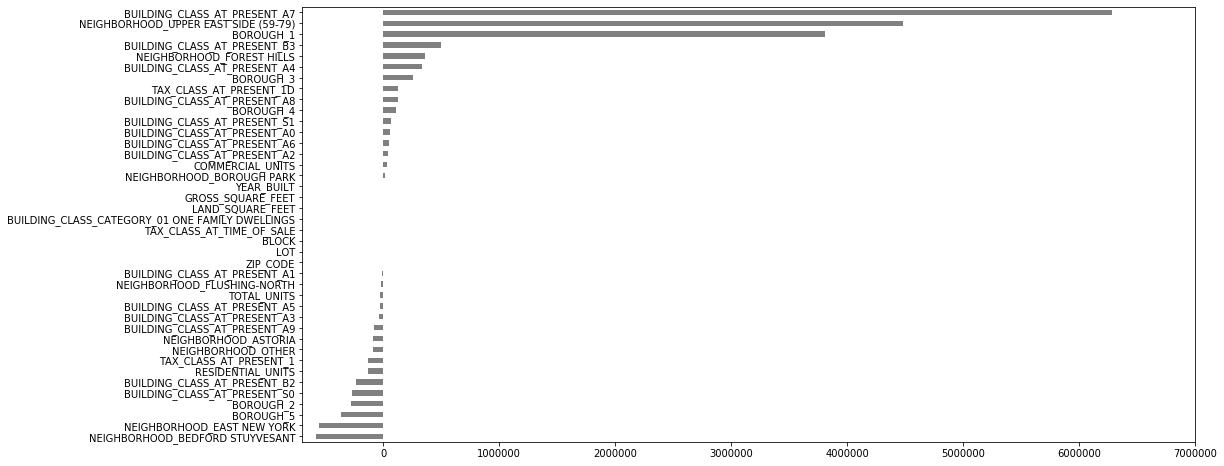

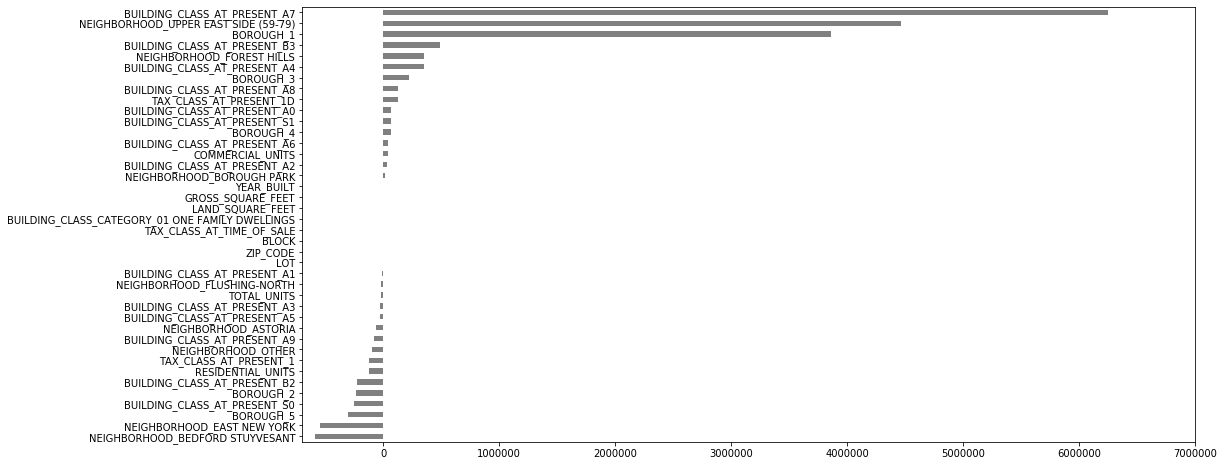

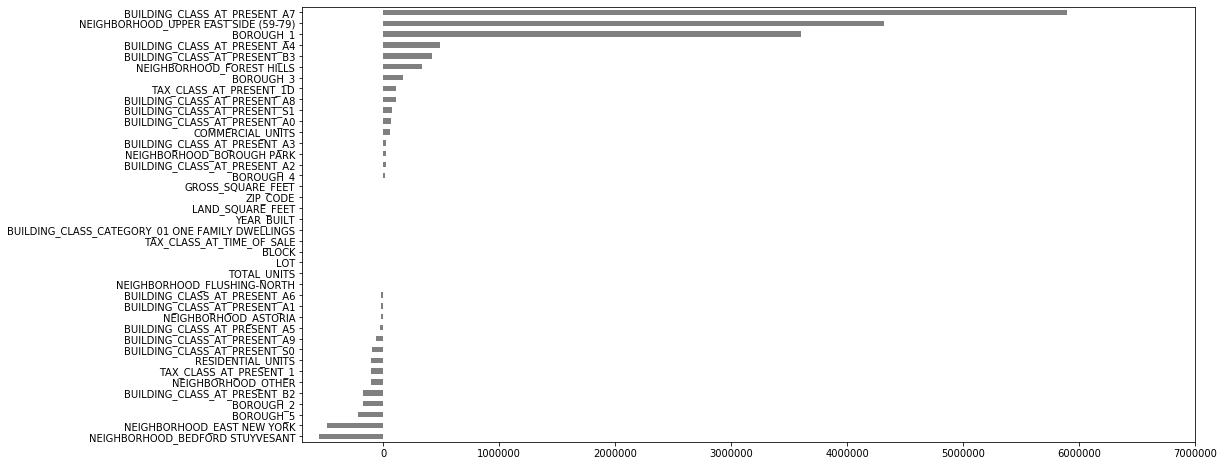

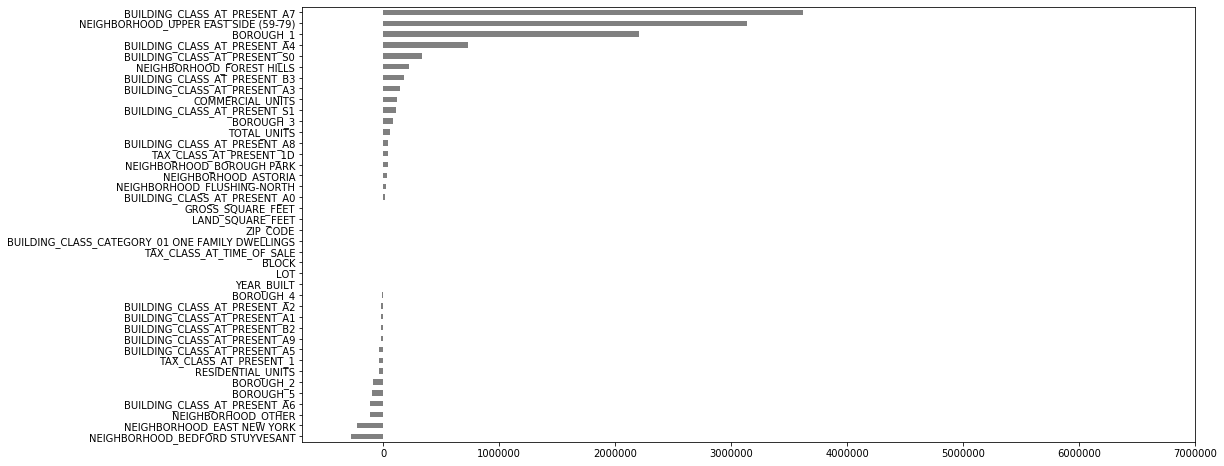

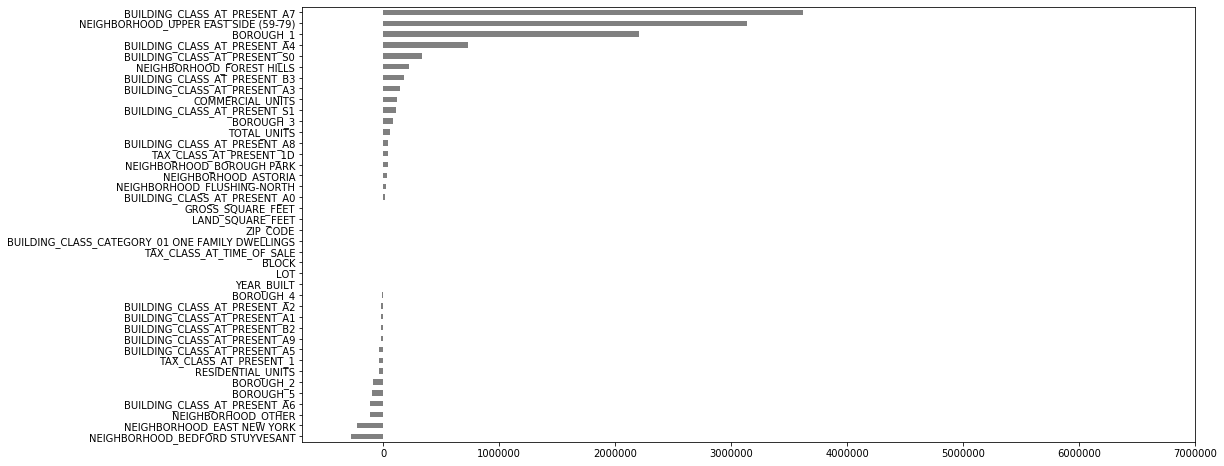

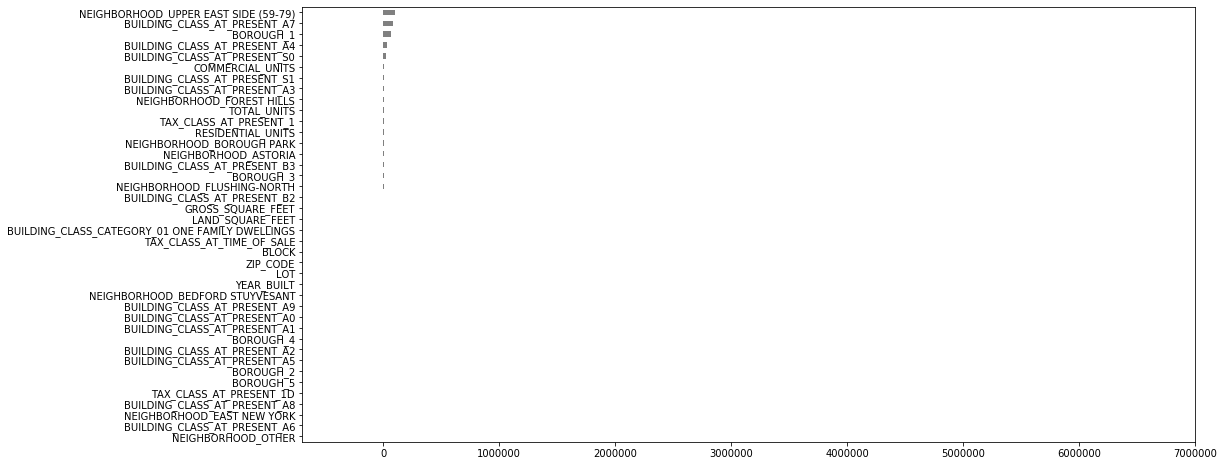

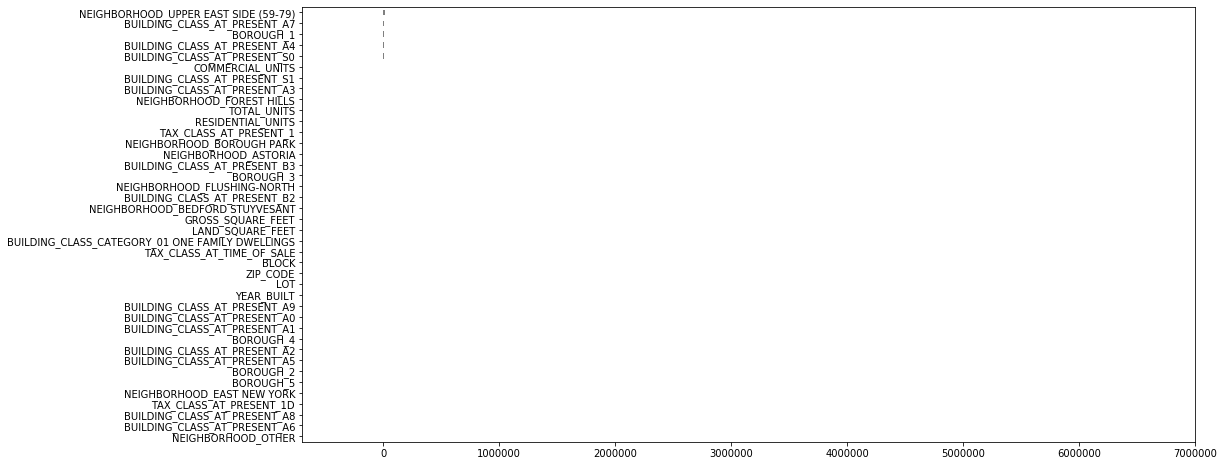

In [56]:
# ridge regression for multiple features
for alpha in [0.001, 0.01, 0.1, 1.0, 1, 100.0, 1000.0]:
    
    # Fit Ridge Regression model
    display(HTML(f'Ridge Regression, with alpha={alpha}'))
    model = Ridge(alpha=alpha, normalize=True)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Get Test MAE
    mae = mean_absolute_error(y_test, y_pred)
    display(HTML(f'Test Mean Absolute Error: ${mae:,.0f}'))
    
    # Plot coefficients
    coefficients = pd.Series(model.coef_, X_train.columns)
    plt.figure(figsize=(16,8))
    coefficients.sort_values().plot.barh(color='grey')
    plt.xlim(-700000,7000000)
    plt.show()

In [42]:
coefficients = pd.Series(model.coef_, X_train.columns)
coefficients

BOROUGH_3                                            237.835621
BOROUGH_4                                            -97.401481
BOROUGH_2                                           -181.380833
BOROUGH_5                                           -235.031817
BOROUGH_1                                           6434.900361
NEIGHBORHOOD_OTHER                                  -578.658621
NEIGHBORHOOD_FLUSHING-NORTH                          149.422165
NEIGHBORHOOD_EAST NEW YORK                          -299.416981
NEIGHBORHOOD_BEDFORD STUYVESANT                       16.347897
NEIGHBORHOOD_FOREST HILLS                            732.023528
NEIGHBORHOOD_BOROUGH PARK                            295.384817
NEIGHBORHOOD_UPPER EAST SIDE (59-79)               10020.447583
NEIGHBORHOOD_ASTORIA                                 288.215572
BUILDING_CLASS_CATEGORY_01 ONE FAMILY DWELLINGS        0.000000
TAX_CLASS_AT_PRESENT_1                               321.137925
TAX_CLASS_AT_PRESENT_1D                 